## Amazon Fine Food Review - Clustering Algorithm -- KMeans 

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(87773, 10)


In [8]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn','would', "wouldn't"])

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:55<00:00, 1593.44it/s]


## Applying Clustering Algorithm -- KMeans

### SET 1 : BAG OF WORDS (BOW)

In [11]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from plotly.plotly import plotly as py
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans

In [12]:
final['Cleaned_Text']=preprocessed_reviews
final.head()

Id   ProductId          UserId    ProfileName  HelpfulnessNumerator  \
0  76882  B00002N8SM  A32DW342WBJ6BX    Buttersugar                     0   
1   1245  B00002Z754  A29Z5PI9BW2PU3         Robbie                     7   
2   1244  B00002Z754  A3B8RCEI0FXFI6      B G Chase                    10   
3  30629  B00008RCMI  A19E94CF5O1LY7  Andrew Arnold                     0   
4  30630  B00008RCMI  A284C7M23F0APC     A. Mendoza                     0   

   HelpfulnessDenominator  Score        Time  \
0                       0      1   948672000   
1                       7      1   961718400   
2                      10      1   962236800   
3                       0      1  1067040000   
4                       0      1  1067040000   

                                      Summary  \
0                      A sure death for flies   
1                               Great Product   
2              WOW Make your own 'slickers' !   
3  I've chewed this gum many times, but used?   
4                    Best sugarless gum ever!   

                                                Text  \
0  I bought a few of these after my apartment was...   
1  This was a really good idea and the final prod...   
2  I just received my shipment and could hardly w...   
3  Nothing against the product, but it does bothe...   
4  I love this stuff. It is sugar-free so it does...   

                                        Cleaned_Text  
0  bought apartment infested fruit flies hours tr...  
1  really good idea final product outstanding use...  
2  received shipment could hardly wait try produc...  
3  nothing product bother link top page buy used ...  
4  love stuff sugar free rot gums tastes good goi...

In [13]:
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [391]:
# BoW -- transform with unigram and bigram

ngram_vect = CountVectorizer(min_df=10)
D1_Train = ngram_vect.fit_transform(X['Cleaned_Text'])
print(D1_Train.shape)

(87773, 11521)


In [392]:
n_train = D1_Train.get_shape()[0]
print(n_train)

87773


In [393]:
# Standardization Process
# Changes done as suggested

scaler = MaxAbsScaler()
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)

print(D1_Train.shape)

(87773, 11521)


In [394]:
D1_Train=D1_Train.astype('int')

In [443]:
# Applying KMeans++ 

clusters = 10
train_inertia = []

for i in tqdm(range(1,clusters+1)):
    km = KMeans(n_clusters=i, random_state=0)
    
    predicted_interia = []
    
    # Fitting the model in Train - CrossValidation
    
    km.fit(D1_Train)
    print(km.inertia_)    
    predicted_interia.append(km.inertia_)
    train_inertia.append(km.inertia_)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

87836.30544696673


 10%|████████▎                                                                          | 1/10 [01:03<09:32, 63.63s/it]

87781.68768957324


 20%|████████████████▌                                                                  | 2/10 [02:15<08:49, 66.16s/it]

87726.62879455186


 30%|████████████████████████▉                                                          | 3/10 [03:25<07:50, 67.20s/it]

87503.84574374575


 40%|█████████████████████████████████▏                                                 | 4/10 [04:33<06:45, 67.57s/it]

87408.84978020284


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:39<05:34, 66.88s/it]

87368.02503060833


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [06:46<04:28, 67.19s/it]

87361.20202200966


 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:04<03:30, 70.27s/it]

87249.94593387241


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [09:14<02:20, 70.17s/it]

87135.20847712054


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [10:28<01:11, 71.51s/it]

87195.05106404475


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:58<00:00, 77.05s/it]


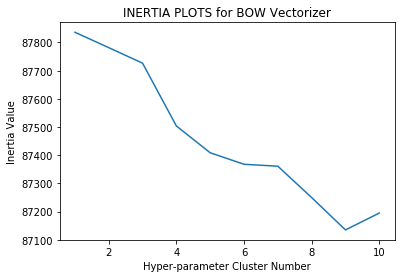

In [444]:
# Plotting Inertia_ against Number of CLusters
plt.plot(range(1,clusters+1),train_inertia)
plt.title("INERTIA PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

In [466]:
# Applying KMeans++ on Test Data

km1_test = KMeans(n_clusters=9, random_state=0)   
    
# Fitting the model in Train - CrossValidation
km1_test.fit(D1_Train)
print(km1_test.inertia_)    
print(km1_test.labels_)

87135.20847712054
[1 1 1 ... 1 1 1]


In [467]:
labels = km1_test.labels_
X['Clusters_Label'] = labels
X.head(10)

Cleaned_Text  Clusters_Label
0   bought apartment infested fruit flies hours tr...               1
1   really good idea final product outstanding use...               1
2   received shipment could hardly wait try produc...               1
3   nothing product bother link top page buy used ...               1
4   love stuff sugar free rot gums tastes good goi...               1
5   never tried kona coffee aloha island definitel...               1
7   fresh limes underappreciated joy kitchen squir...               1
8   grocery store kinds gourmet coffees laid one t...               1
9   blend one starbucks gentler blends like taste ...               1
10  chatchi favorite afternoon treat became myster...               1

In [468]:
final_cluster1 = X.loc[X['Clusters_Label'] == 1]
final_cluster2 = X.loc[X['Clusters_Label'] == 2]
final_cluster0 = X.loc[X['Clusters_Label'] == 0]
final_cluster3 = X.loc[X['Clusters_Label'] == 3]

final_cluster4 = X.loc[X['Clusters_Label'] == 4]
final_cluster5 = X.loc[X['Clusters_Label'] == 5]
final_cluster6 = X.loc[X['Clusters_Label'] == 6]
final_cluster7 = X.loc[X['Clusters_Label'] == 7]
final_cluster8 = X.loc[X['Clusters_Label'] == 8]

In [448]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

Word CLoud for Cluster 1 :


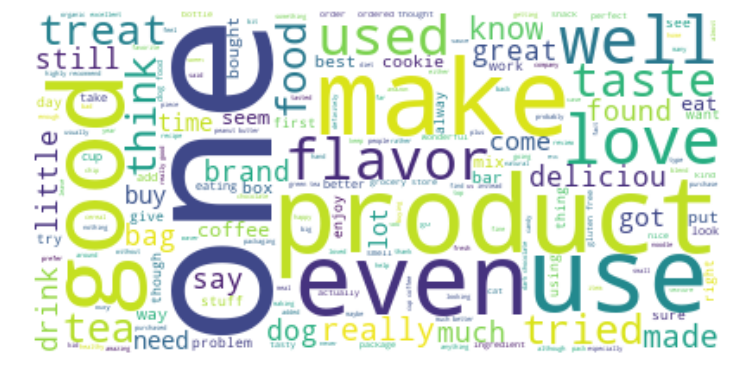

In [469]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 2 :


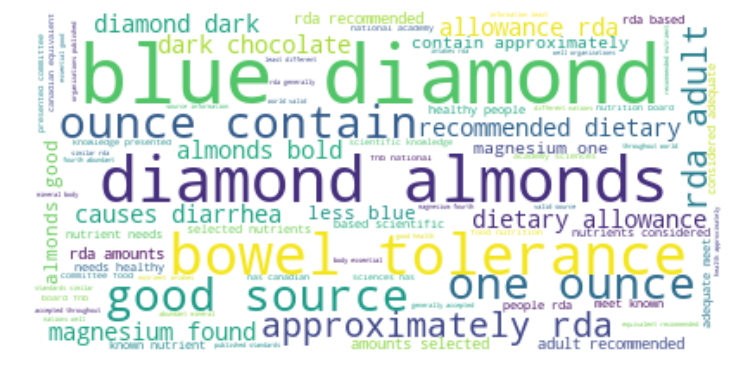

In [470]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(final_cluster2['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 3 :


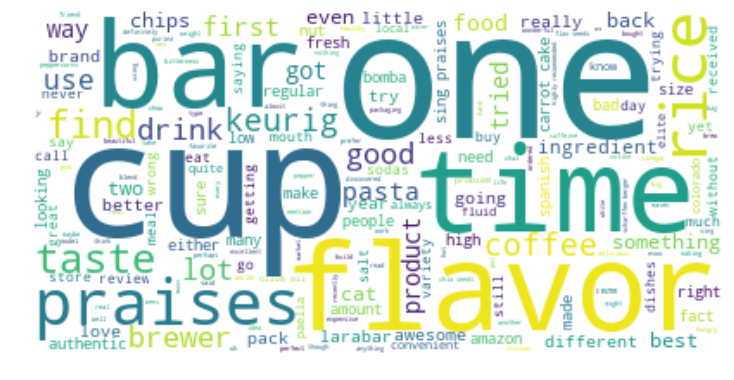

In [464]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(final_cluster3['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 4 :


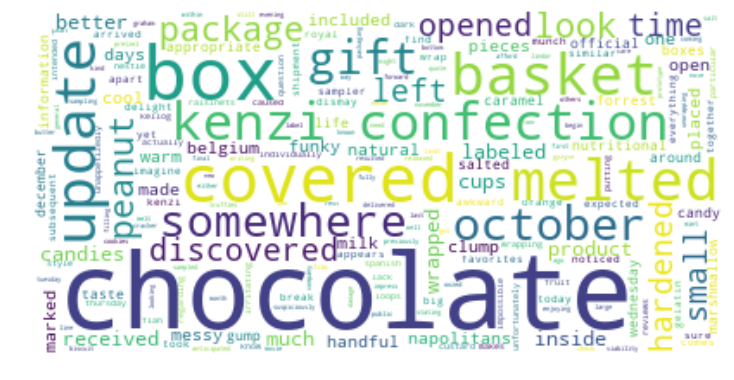

In [471]:
print("Word CLoud for Cluster 4 :")

bow_features = " ".join(final_cluster4['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary :
    This cluster has words like chocolate,candies etc. Thus cluster is maybe describing sweet products.

Word CLoud for Cluster 5 :


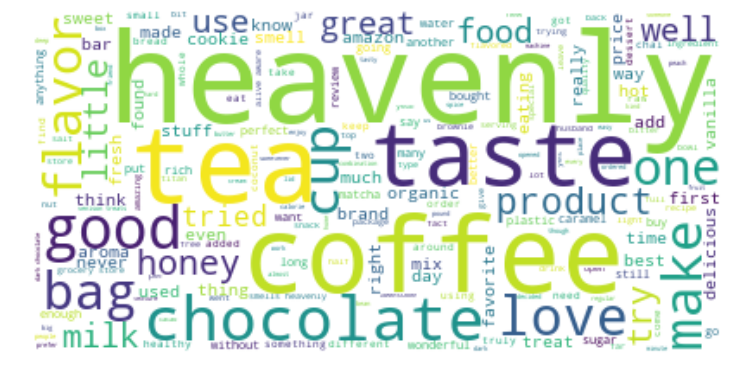

In [472]:
print("Word CLoud for Cluster 5 :")

bow_features = " ".join(final_cluster5['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary : 
    This cluster contains words like tea,coffee,flavour,taste,aroma etc. It mainly shows beverages. It also shows some products that accompany such bevarges like cup,honey,sweet,sugar,cup,cookie,milk etc. It also contains words like great,good,well,favourite,best,right,delicious,heavenly. These might be an indicator that the reviews in the cluster is mainly positive.

Word CLoud for Cluster 0 :


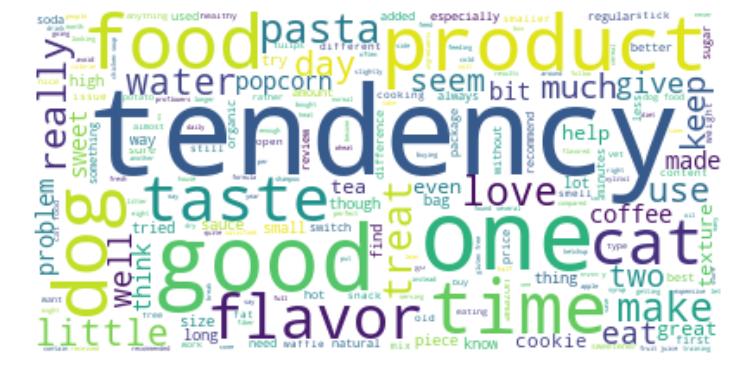

In [473]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 6 :


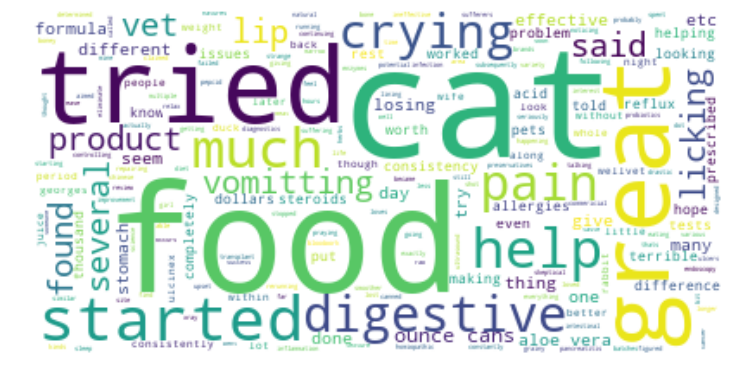

In [476]:
print("Word CLoud for Cluster 6 :")

bow_features = " ".join(final_cluster6['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 7 :


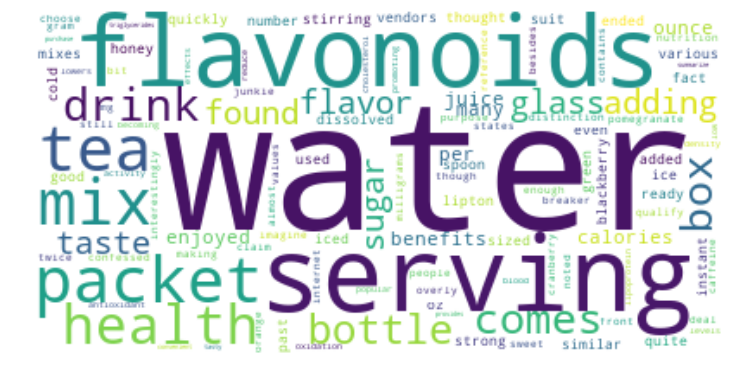

In [475]:
print("Word CLoud for Cluster 7 :")

bow_features = " ".join(final_cluster7['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary : This cluster has words like tea,drink,water,health etc. This cluster is describing tea.

Word CLoud for Cluster 8 :


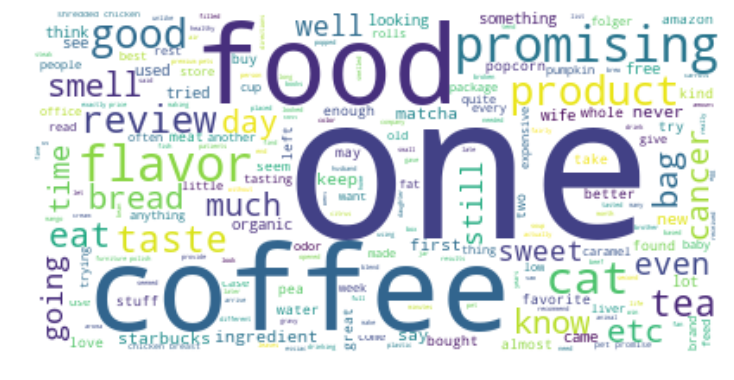

In [474]:
print("Word CLoud for Cluster 8 :")

bow_features = " ".join(final_cluster8['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Summary : This cluster has words like coffee,flavor,smell,taste,starbucks etc. This cluster is describing coffee .

### 1.2) Applying KMeans on Tf-Idf Vectorizer

In [395]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape)

Some feature names :  ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
(87773, 49879)


In [396]:
# Standardization Process
# Changes done as suggested

scaler = MaxAbsScaler()
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)

print(D2_Train.shape)

(87773, 49879)


In [397]:
D2_Train=D2_Train.astype('int')

In [427]:
# Applying KMeans++ 

clusters = 10
train_inertia = []

for i in tqdm(range(1,clusters+1)):
    km2 = KMeans(n_clusters=i, random_state=0,verbose=1)
    
    predicted_interia = []
    
    # Fitting the model in Train - CrossValidation
    
    km2.fit(D2_Train)
    print(km2.inertia_)    
    predicted_interia.append(km2.inertia_)
    train_inertia.append(km2.inertia_)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42963.000
Iteration  1, inertia 42962.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 10%|████████▎                                                                          | 1/10 [01:27<13:09, 87.75s/it]

Initialization complete
Iteration  0, inertia 42962.000
Iteration  1, inertia 42961.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42962.000
Iteration  1, inertia 42961.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42962.000
Iteration  1, inertia 42961.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42961.000
Iteration  1, inertia 42960.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42960.000
Iteration  1, inertia 42959.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42962.000
Iteration  1, inertia 42961.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 20%|████████████████▌                                                                  | 2/10 [02:51<11:31, 86.48s/it]

Initialization complete
Iteration  0, inertia 42961.000
Iteration  1, inertia 42960.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42960.000
Iteration  1, inertia 42959.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42956.000
Iteration  1, inertia 42955.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42961.000
Iteration  1, inertia 42960.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42957.000
Iteration  1, inertia 42956.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42956.000
Iteration  1, inertia 42955.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 30%|████████████████████████▉                                                          | 3/10 [04:16<10:03, 86.23s/it]

Initialization complete
Iteration  0, inertia 42959.000
Iteration  1, inertia 42958.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42954.000
Iteration  1, inertia 42953.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42957.000
Iteration  1, inertia 42956.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42957.000
Iteration  1, inertia 42956.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42957.000
Iteration  1, inertia 42956.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42957.000
Iteration  1, inertia 42956.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 40%|█████████████████████████████████▏                                                 | 4/10 [05:42<08:36, 86.11s/it]

Initialization complete
Iteration  0, inertia 42956.000
Iteration  1, inertia 42955.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42951.000
Iteration  1, inertia 42950.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42950.000
Iteration  1, inertia 42949.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42956.000
Iteration  1, inertia 42955.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42958.000
Iteration  1, inertia 42957.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42954.000
Iteration  1, inertia 42953.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 50%|█████████████████████████████████████████▌                                         | 5/10 [07:17<07:23, 88.78s/it]

Initialization complete
Iteration  0, inertia 42954.000
Iteration  1, inertia 42953.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42952.000
Iteration  1, inertia 42951.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42949.000
Iteration  1, inertia 42948.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42952.000
Iteration  1, inertia 42951.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42952.000
Iteration  1, inertia 42951.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42952.000
Iteration  1, inertia 42951.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [08:54<06:04, 91.14s/it]

Initialization complete
Iteration  0, inertia 42951.000
Iteration  1, inertia 42950.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42949.000
Iteration  1, inertia 42948.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42955.000
Iteration  1, inertia 42954.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42951.000
Iteration  1, inertia 42950.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42947.000
Iteration  1, inertia 42946.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42947.000
Iteration  1, inertia 42946.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 70%|██████████████████████████████████████████████████████████                         | 7/10 [10:41<04:47, 95.80s/it]

Initialization complete
Iteration  0, inertia 42947.000
Iteration  1, inertia 42946.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42946.000
Iteration  1, inertia 42945.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42945.000
Iteration  1, inertia 42944.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42945.000
Iteration  1, inertia 42944.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42950.000
Iteration  1, inertia 42949.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42947.000
Iteration  1, inertia 42946.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [12:19<03:13, 96.57s/it]

Initialization complete
Iteration  0, inertia 42946.000
Iteration  1, inertia 42945.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42870.000
Iteration  1, inertia 42869.510
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42943.000
Iteration  1, inertia 42942.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42944.000
Iteration  1, inertia 42943.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42945.000
Iteration  1, inertia 42944.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42944.000
Iteration  1, inertia 42943.504
Converged at iteration 1: center shift 0.000000e+00 within tol

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [13:57<01:37, 97.17s/it]

Initialization complete
Iteration  0, inertia 42944.000
Iteration  1, inertia 42943.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42943.000
Iteration  1, inertia 42942.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42940.000
Iteration  1, inertia 42939.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42936.000
Iteration  1, inertia 42935.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42944.000
Iteration  1, inertia 42943.504
Converged at iteration 1: center shift 0.000000e+00 within tolerance 9.813206e-10
Initialization complete
Iteration  0, inertia 42940.000
Iteration  1, inertia 42939.504
Converged at iteration 1: center shift 0.000000e+00 within tol

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:38<00:00, 98.03s/it]


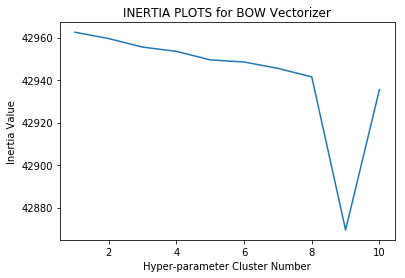

In [428]:
# Plotting Inertia_ against Number of CLusters
plt.plot(range(1,clusters+1),train_inertia)
plt.title("INERTIA PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

In [429]:
# Applying KMeans++ on Test Data

km2_test = KMeans(n_clusters=9, random_state=0)   
    
# Fitting the model in Train - CrossValidation
km2_test.fit(D2_Train)
print(km2_test.inertia_)    
print(km2_test.labels_)

42869.51035804575
[0 0 0 ... 0 0 0]


In [430]:
print(len(km2_test.labels_))

87773


In [431]:
labels = km2_test.labels_
X['Clusters_Label'] = labels
X.head(5)

Cleaned_Text  Clusters_Label
0  bought apartment infested fruit flies hours tr...               0
1  really good idea final product outstanding use...               0
2  received shipment could hardly wait try produc...               0
3  nothing product bother link top page buy used ...               0
4  love stuff sugar free rot gums tastes good goi...               0

In [433]:
final_cluster1 = X.loc[X['Clusters_Label'] == 1]
final_cluster2 = X.loc[X['Clusters_Label'] == 2]
final_cluster3 = X.loc[X['Clusters_Label'] == 3]
final_cluster0 = X.loc[X['Clusters_Label'] == 0]
final_cluster4 = X.loc[X['Clusters_Label'] == 4]
final_cluster5 = X.loc[X['Clusters_Label'] == 5]
final_cluster6 = X.loc[X['Clusters_Label'] == 6]
final_cluster7 = X.loc[X['Clusters_Label'] == 7]
final_cluster8 = X.loc[X['Clusters_Label'] == 8]

Word Cloud for Cluster 0 :


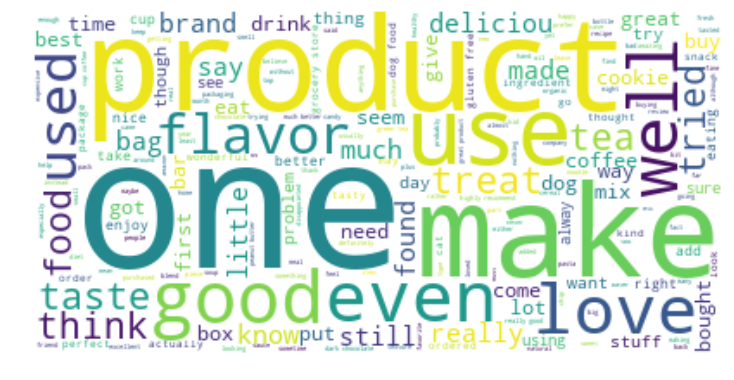

In [434]:
print("Word Cloud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 1 :


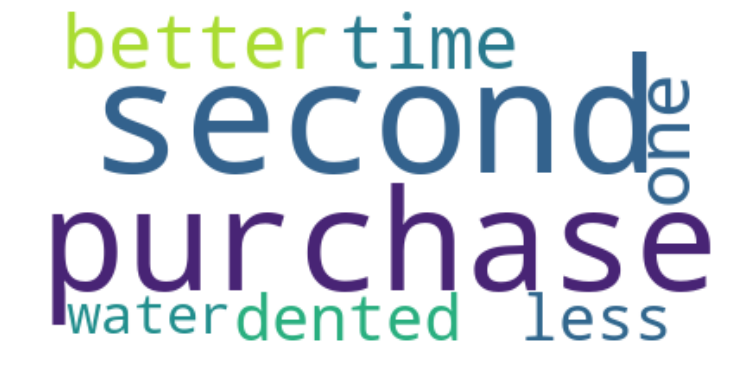

In [435]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 2 :


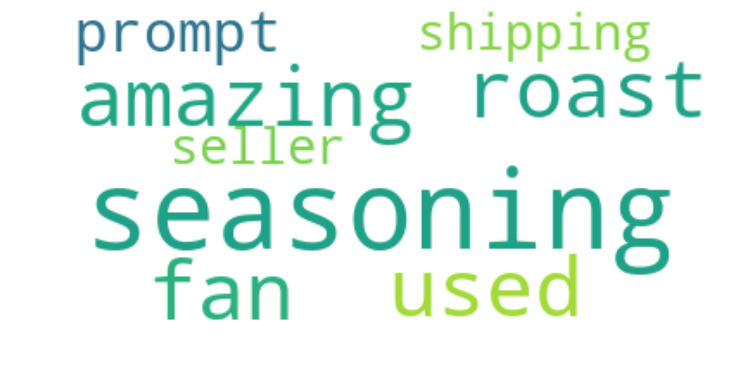

In [436]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(final_cluster2['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 3 :


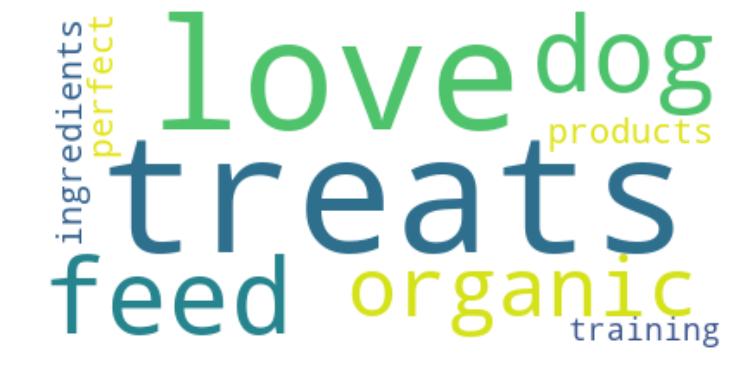

In [437]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(final_cluster3['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 4 :


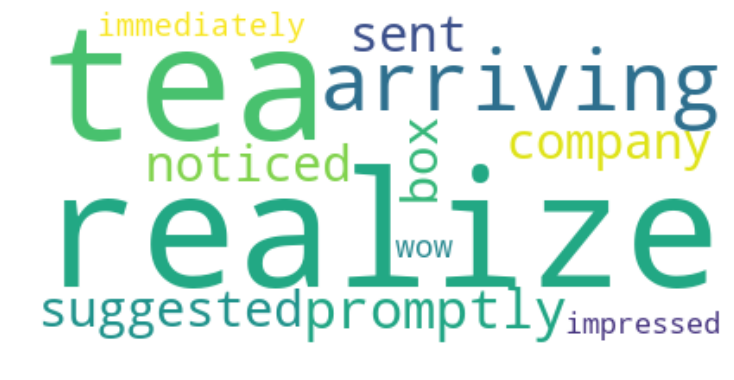

In [438]:
print("Word CLoud for Cluster 4 :")

bow_features = " ".join(final_cluster4['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 5 :


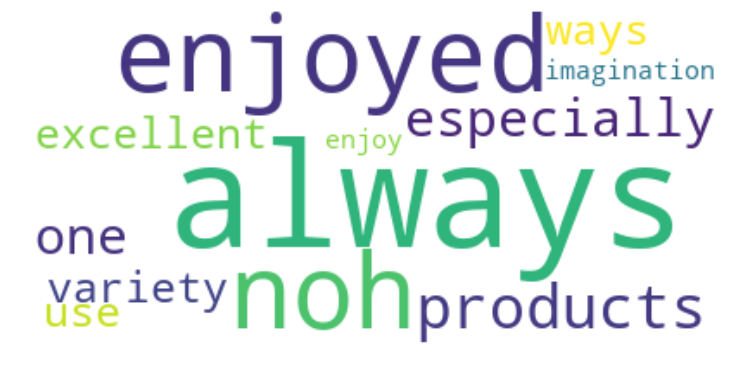

In [439]:
print("Word CLoud for Cluster 5 :")

bow_features = " ".join(final_cluster5['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 6 :


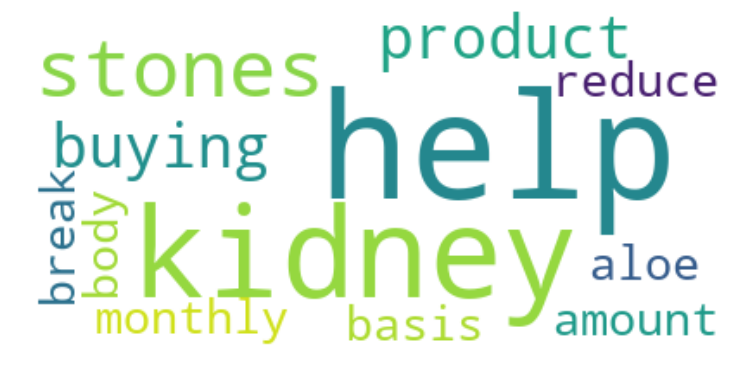

In [440]:
print("Word CLoud for Cluster 6 :")

bow_features = " ".join(final_cluster6['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 7 :


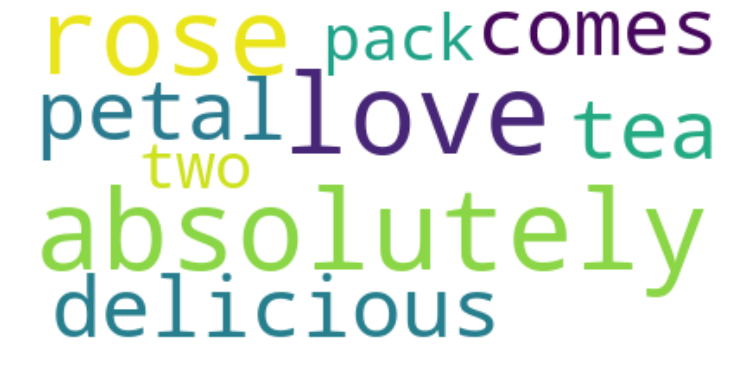

In [441]:
print("Word CLoud for Cluster 7 :")

bow_features = " ".join(final_cluster7['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 8 :


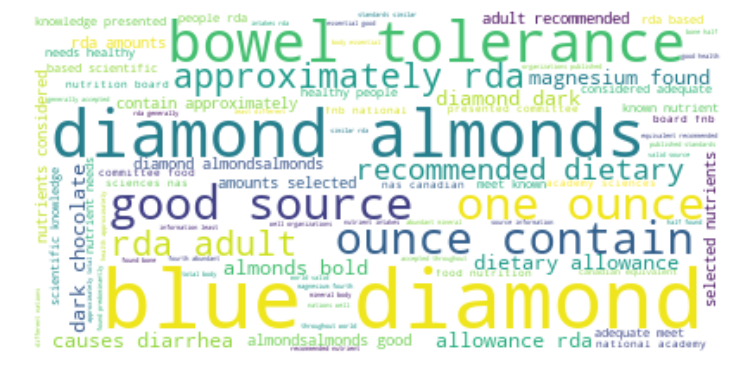

In [442]:
print("Word CLoud for Cluster 8 :")

bow_features = " ".join(final_cluster8['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 1.3) Applying Kmeans on Word2Vec Vectorizer

In [398]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

87773
[('great', 0.8428406715393066), ('decent', 0.842616856098175), ('fantastic', 0.7698241472244263), ('terrific', 0.7494469881057739), ('awesome', 0.7434367537498474), ('amazing', 0.7228115200996399), ('excellent', 0.703109622001648), ('nice', 0.6692653894424438), ('wonderful', 0.6383183002471924), ('delicious', 0.6318386793136597)]
Total Words Present  17383
Sample Words :  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within']


In [399]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [05:14<00:00, 279.52it/s]


87773
[-0.37734655  0.28904346  0.12387108  0.10786696 -0.72439401  0.26034443
 -0.44053345  0.0366857  -0.19178765 -0.36508138  0.20153037 -0.00701762
 -0.22954437  0.21083988  0.00224585  0.30283624 -0.33465398  0.19075542
 -0.55259364  0.5754035   0.15837439 -0.33751518 -0.31385408  0.13661496
  0.51819822  0.24670452  0.14767024 -0.1031329  -0.30201212  0.63406729
  0.56420904  0.11674069  0.2769187   0.06671778  0.16514939 -0.71772843
  0.12093435  0.72546253 -0.00671383 -0.22605548  0.09941757 -0.41181901
  0.29033757  0.45045499  0.15212384 -0.32678272  0.47470468 -0.05740294
 -0.34043436  0.29208216]


In [400]:
n_train = len(sent_vect_train)
print(n_train)

87773


In [401]:
D3_Train = np.array(sent_vect_train)

In [415]:
# Applying KMeans++ 

clusters = 10
train_inertia = []

for i in tqdm(range(1,clusters+1)):
    km3 = KMeans(n_clusters=i, random_state=0)
    
    predicted_interia = []
    
    # Fitting the model in Train - CrossValidation
    
    km3.fit(D3_Train)
    print(km3.inertia_)    
    predicted_interia.append(km3.inertia_)
    train_inertia.append(km3.inertia_)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

926093.4437393624


 10%|████████▎                                                                          | 1/10 [00:07<01:03,  7.05s/it]

825871.247089308


 20%|████████████████▌                                                                  | 2/10 [00:13<00:54,  6.81s/it]

754039.0726267286


 30%|████████████████████████▉                                                          | 3/10 [00:20<00:48,  6.94s/it]

703528.8450248501


 40%|█████████████████████████████████▏                                                 | 4/10 [00:27<00:41,  6.98s/it]

679315.6070840618


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:43<00:47,  9.58s/it]

659122.0631000852


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:03<00:50, 12.68s/it]

640543.0756274075


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:26<00:47, 16.00s/it]

626943.0602374239


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:47<00:34, 17.27s/it]

614430.6642259697


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:07<00:18, 18.24s/it]

605407.7909423955


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:36<00:00, 21.35s/it]


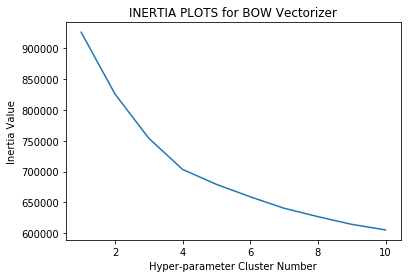

In [416]:
# Plotting Inertia_ against Number of CLusters
plt.plot(range(1,clusters+1),train_inertia)
plt.title("INERTIA PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

In [417]:
# Applying KMeans++ on Test Data

km3_test = KMeans(n_clusters=4, random_state=0)   
    
# Fitting the model in Train - CrossValidation
km3_test.fit(D3_Train)
print(km3_test.inertia_)    
print(km3_test.labels_)

703528.8450248501
[2 3 3 ... 1 1 2]


In [418]:
print(len(km3_test.labels_))

87773


In [419]:
labels = km3_test.labels_
X['Clusters_Label'] = labels
X.head(10)

Cleaned_Text  Clusters_Label
0   bought apartment infested fruit flies hours tr...               2
1   really good idea final product outstanding use...               3
2   received shipment could hardly wait try produc...               3
3   nothing product bother link top page buy used ...               3
4   love stuff sugar free rot gums tastes good goi...               1
5   never tried kona coffee aloha island definitel...               0
7   fresh limes underappreciated joy kitchen squir...               1
8   grocery store kinds gourmet coffees laid one t...               0
9   blend one starbucks gentler blends like taste ...               0
10  chatchi favorite afternoon treat became myster...               1

In [420]:
final_cluster1 = X.loc[X['Clusters_Label'] == 1]

In [421]:
final_cluster2 = X.loc[X['Clusters_Label'] == 2]
final_cluster3 = X.loc[X['Clusters_Label'] == 3]
final_cluster0 = X.loc[X['Clusters_Label'] == 0]

In [422]:
final_cluster2.head(5)

Cleaned_Text  Clusters_Label
0   bought apartment infested fruit flies hours tr...               2
43      supposed avoid sugars urinary tract infection               2
62  stuff really nice around special treat cat int...               2
63  searched food full preservatives fillers cost ...               2
64  according cat stuff great licks hours eating o...               2

Word CLoud for Cluster 1 :


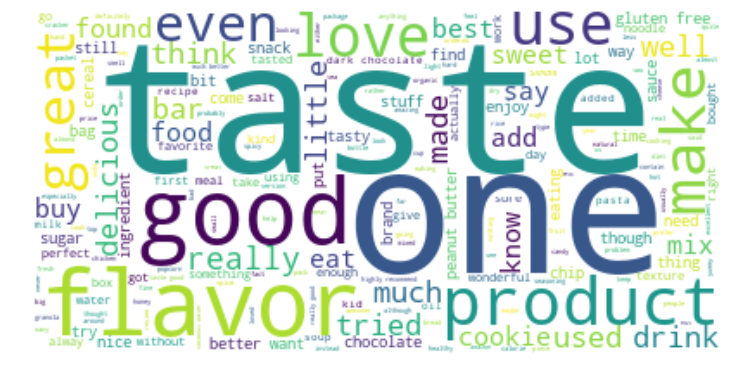

In [423]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 2 :


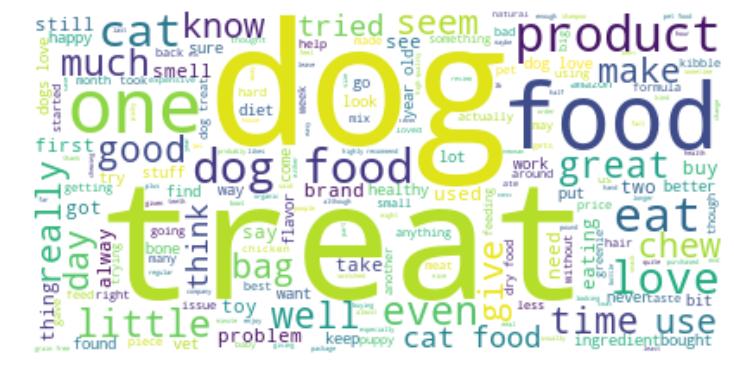

In [424]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(final_cluster2['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 3 :


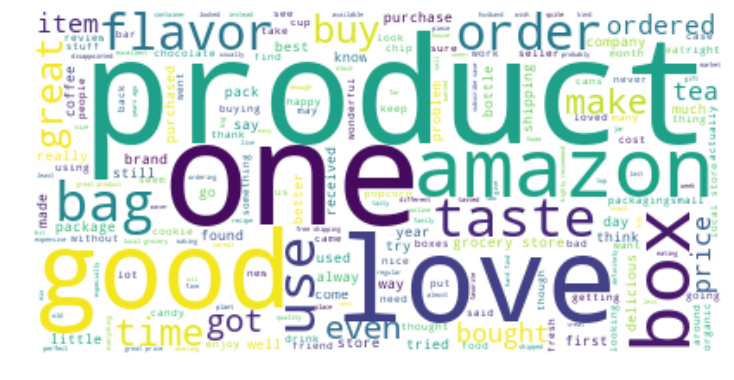

In [425]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(final_cluster3['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 0 :


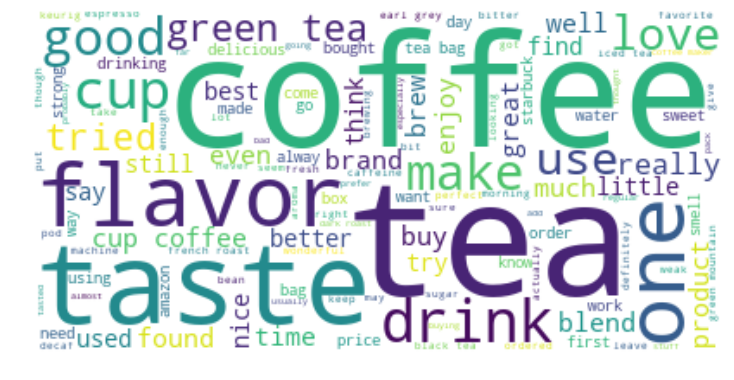

In [426]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 1.4) Applying KMeans to Tf-Idf_Weighted Word2Vec

In [402]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

87773


In [403]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [1:52:38<00:00, 12.99it/s]


87773


In [404]:
n_train = len(tfidf_w2v_train)
print(n_train)

87773


In [405]:
D4_Train = np.array(tfidf_w2v_train)

In [406]:
# Applying KMeans++ 

clusters = 10
train_inertia = []

for i in tqdm(range(1,clusters+1)):
    km4 = KMeans(n_clusters=i, random_state=0)
    
    predicted_interia = []
    
    # Fitting the model in Train - CrossValidation
    
    km4.fit(D4_Train)
    print(km4.inertia_)    
    predicted_interia.append(km4.inertia_)
    train_inertia.append(km4.inertia_)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

1311040.979824644


 10%|████████▎                                                                          | 1/10 [00:16<02:26, 16.26s/it]

1158126.8237087775


 20%|████████████████▌                                                                  | 2/10 [00:28<01:59, 14.98s/it]

1062442.0630923454


 30%|████████████████████████▉                                                          | 3/10 [00:35<01:28, 12.63s/it]

990441.082814932


 40%|█████████████████████████████████▏                                                 | 4/10 [00:43<01:06, 11.13s/it]

948567.8078785576


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:53<00:54, 10.97s/it]

915987.6274235755


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:08<00:48, 12.23s/it]

885009.614097334


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:26<00:42, 14.02s/it]

860747.3823625733


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:45<00:30, 15.35s/it]

845967.8936318079


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:05<00:16, 16.75s/it]

831199.0045757402


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 23.79s/it]


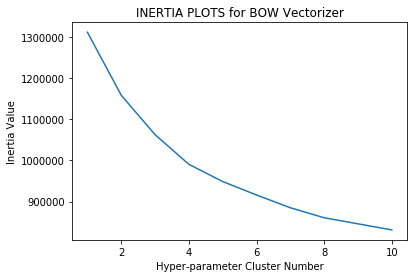

In [407]:
# Plotting Inertia_ against Number of CLusters
plt.plot(range(1,clusters+1),train_inertia)
plt.title("INERTIA PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Cluster Number')
plt.ylabel('Inertia Value')
plt.show()

In [408]:
# Applying KMeans++ on Test Data

km4_test = KMeans(n_clusters=4, random_state=0)   
    
# Fitting the model in Train - CrossValidation
km4_test.fit(D4_Train)
print(km4_test.inertia_)    
print(km4_test.labels_)

990441.082814932
[1 1 1 ... 0 0 3]


In [409]:
labels = km4_test.labels_
X['Clusters_Label'] = labels
X.head(5)

Cleaned_Text  Clusters_Label
0  bought apartment infested fruit flies hours tr...               1
1  really good idea final product outstanding use...               1
2  received shipment could hardly wait try produc...               1
3  nothing product bother link top page buy used ...               1
4  love stuff sugar free rot gums tastes good goi...               0

In [410]:
final_cluster1 = X.loc[X['Clusters_Label'] == 1]
final_cluster2 = X.loc[X['Clusters_Label'] == 2]
final_cluster3 = X.loc[X['Clusters_Label'] == 3]
final_cluster0 = X.loc[X['Clusters_Label'] == 0]

Word CLoud for Cluster 1 :


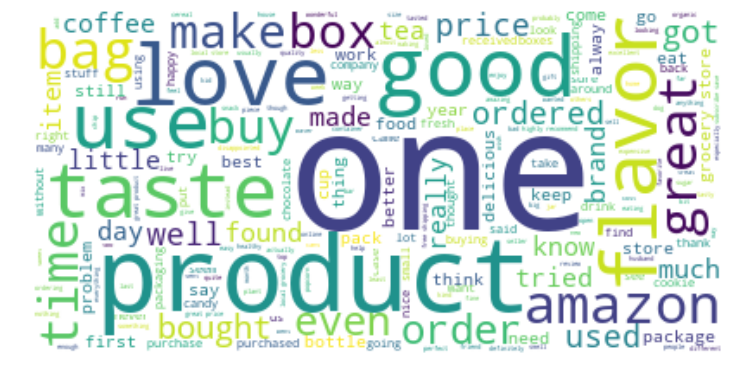

In [411]:
print("Word CLoud for Cluster 1 :")

bow_features = " ".join(final_cluster1['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 2 :


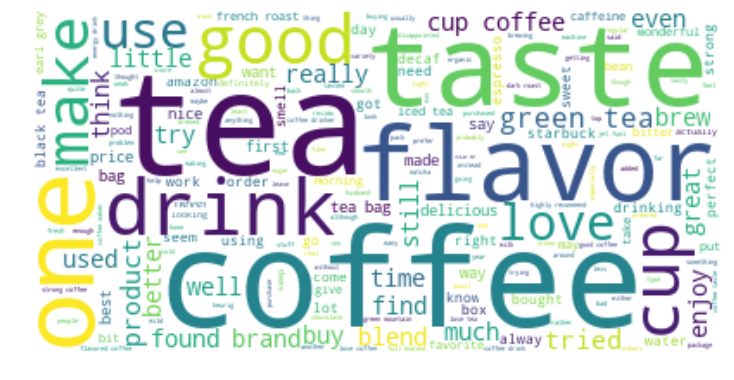

In [412]:
print("Word CLoud for Cluster 2 :")

bow_features = " ".join(final_cluster2['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 3 :


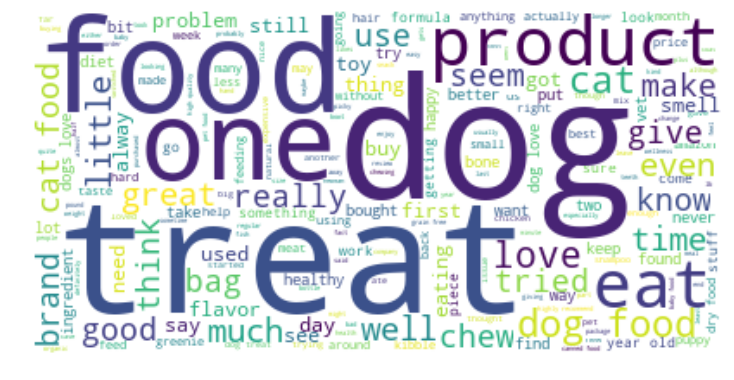

In [413]:
print("Word CLoud for Cluster 3 :")

bow_features = " ".join(final_cluster3['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Word CLoud for Cluster 0 :


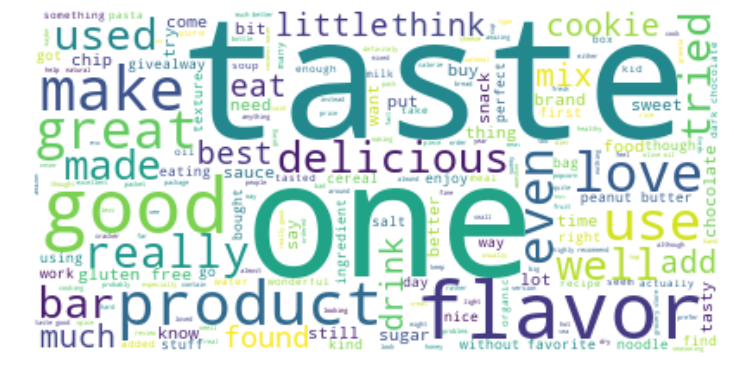

In [414]:
print("Word CLoud for Cluster 0 :")

bow_features = " ".join(final_cluster0['Cleaned_Text'].values)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()